In [2]:
# Imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
from scipy.stats import t
import community 
import community.community_louvain as community_louvain
from networkx.algorithms.community import greedy_modularity_communities

In [4]:
# requirements.txt
# pandas==2.0.3
# networkx==3.1
# matplotlib==3.7.5
# seaborn==0.13.2
# numpy==1.24.3
# scikit-learn==1.3.2
# scipy==1.10.1
# community==1.0.0b1  
# python-louvain==0.16    

# Part 3: Post Feature Engineering EDA
### Motivations for the use of ML Models to detect malicious users over coventional approaches

In [47]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')

figures_dir = os.path.join( "..", "materials", "reports", "figures", "2B")
feature_analysis_path = os.path.join(figures_dir, 'feature_analysis.png')
dataset_imbalance_path = os.path.join(figures_dir, 'dataset_imbalance.png')
personality_similarity_graph_path = os.path.join(processed_dir, 'personality_similarity_graph.pickle')
personality_similarity_network_path = os.path.join(figures_dir, 'personality_similarity_network.png')
check_na_path = os.path.join(figures_dir, 'check_na.png')
feature_histogram_path = os.path.join(figures_dir, 'feature_histogram.png')
feature_boxplot_path = os.path.join(figures_dir, 'feature_boxplot.png')
feature_boxplot_mal_path = os.path.join(figures_dir, 'feature_boxplot_mal.png')

In [9]:
# Read the multi-part Parquet dataset
data = pd.read_parquet(final_dataset_path).reset_index(drop = True)
data.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,False
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,False
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,False
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,False
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,False
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,False
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,False
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,False


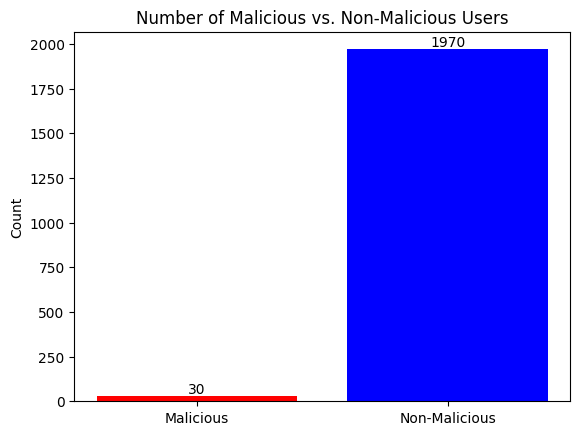

In [48]:
malicious_count = data[data['malicious'] == 1].shape[0]
non_malicious_count = data[data['malicious'] == 0].shape[0]

labels = ['Malicious', 'Non-Malicious']
counts = [malicious_count, non_malicious_count]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=['red', 'blue'])

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

ax.set_title('Number of Malicious vs. Non-Malicious Users')
ax.set_ylabel('Count')
plt.savefig(dataset_imbalance_path)
plt.show()

Comparing 1970 non-malicious users to 30 malicious users highlights a significant class imbalance in the dataset. Given this disparity, implementing oversampling techniques like SMOTE is crucial to balance the dataset and improve the performance of the fraud detection model.

In [68]:
malicious_filenames = answers_dir = os.path.join( "..", "data", "raw_external", 'answers', 'r5.2-2')
malicious_users = []

for filename in malicious_filenames:
    malicious_users.append(filename.replace('r5.2-2-', "").replace('.csv', ""))

malicious_users

['MDS0680',
 'GWG0497',
 'CKP0630',
 'HMS1658',
 'BYO1846',
 'HXP0976',
 'CIF1430',
 'ITA0159',
 'OSS1463',
 'SNK1280',
 'HIS1394',
 'SIS0042',
 'HSN0675',
 'MCP0611',
 'TNB1616',
 'CHP1711',
 'MGB1235',
 'NAH1366',
 'JAL0811',
 'OKM1092',
 'TMT0851',
 'DCC1119',
 'KSS1005',
 'VCF1602',
 'RRS0056',
 'WDT1634',
 'ICB1354',
 'ZIE0741',
 'LVF1626',
 'TRC1838']

In [69]:
data['malicious'] = np.where(data['user'].isin(malicious_users), 1, 0)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


### 3.1 Data Quality Check
#### 3.1.1 General Overview

In [8]:
print(f'Shape of dataset: {data.shape} \n'
      f'Columns of dataset: {data.columns}')

Shape of dataset: (2000, 19) 
Columns of dataset: Index(['user', 'O', 'C', 'E', 'A', 'N', 'FCwke', 'FCowh', 'FCwh', 'SDwke',
       'SDowh', 'SDwh', 'CDwke', 'CDowh', 'CDwh', 'JDwke', 'JDowh', 'JDwh',
       'malicious'],
      dtype='object')


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       2000 non-null   string
 1   O          2000 non-null   int8  
 2   C          2000 non-null   int8  
 3   E          2000 non-null   int8  
 4   A          2000 non-null   int8  
 5   N          2000 non-null   int8  
 6   FCwke      2000 non-null   int16 
 7   FCowh      2000 non-null   int16 
 8   FCwh       2000 non-null   int16 
 9   SDwke      2000 non-null   int16 
 10  SDowh      2000 non-null   int16 
 11  SDwh       2000 non-null   int16 
 12  CDwke      2000 non-null   int16 
 13  CDowh      2000 non-null   int16 
 14  CDwh       2000 non-null   int16 
 15  JDwke      2000 non-null   int16 
 16  JDowh      2000 non-null   int16 
 17  JDwh       2000 non-null   int16 
 18  malicious  2000 non-null   int64 
dtypes: int16(12), int64(1), int8(5), string(1)
memory usage: 88.0 KB


FC(file copy) 

SD (suspicious domain), 
CD (cloud domain), 
JD (job domain), 

wke(weekend), owh(outside work hours), wh(workhours)


In [10]:
data.describe()

,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,33.016000,31.61650,28.561000,28.942500,29.550500,7.285500,31.248500,163.449000,7.241000,39.929500,293.568000,2.831500,11.662500,109.808000,22.809000,128.904500,949.242500,0.015000
std,10.441468,11.05018,11.084977,11.037396,4.993688,53.901138,135.826872,561.057448,61.279373,84.167165,492.934247,26.049499,31.572171,260.608026,139.738194,206.811559,1213.075798,0.121583
min,10.000000,10.00000,10.000000,10.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,21.00000,19.000000,19.750000,26.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.750000,0.000000,0.000000,0.000000,0.000000,5.000000,99.750000,0.000000
50%,36.000000,35.00000,26.000000,28.000000,30.000000,0.000000,0.000000,0.000000,0.000000,8.000000,98.000000,0.000000,0.000000,4.000000,0.000000,42.000000,484.500000,0.000000
75%,41.000000,41.00000,39.000000,39.000000,33.000000,0.000000,0.000000,0.000000,0.000000,44.000000,365.000000,0.000000,5.250000,76.000000,0.000000,159.000000,1389.500000,0.000000
max,50.000000,50.00000,50.000000,50.000000,48.000000,1060.000000,1204.000000,4007.000000,1702.000000,1122.000000,4467.000000,492.000000,488.000000,2054.000000,3037.000000,1779.000000,13126.000000,1.000000


#### 3.1.2 Check missing data points

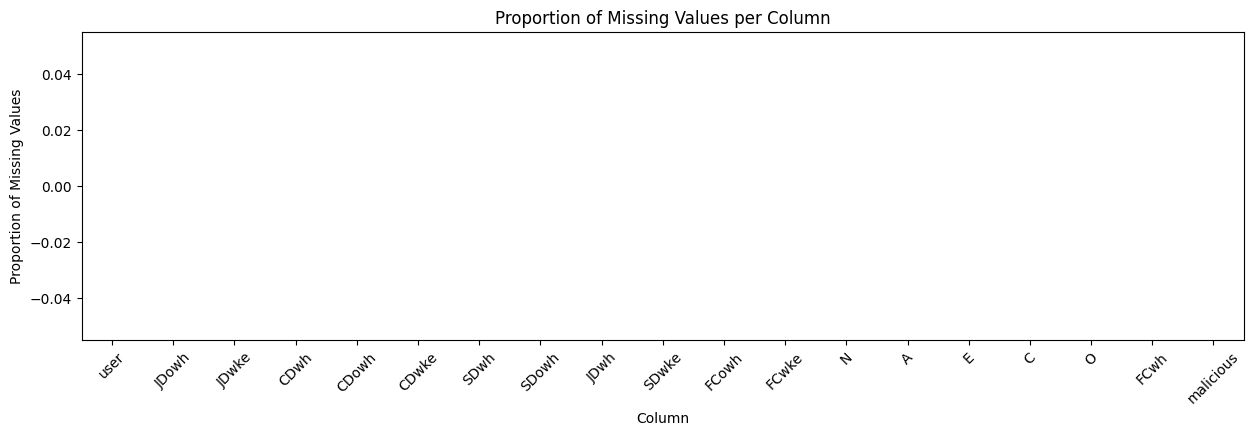

In [38]:
fig = data.isna().mean().sort_values().plot(
    kind='bar', figsize=(15, 4), title='Proportion of Missing Values per Column', 
    ylabel='Proportion of Missing Values', xlabel='Column', rot=45
);
plt.savefig(check_na_path)
plt.show()

- We have successfully assessed the overall quality of our feature-engineered dataset. 
- The dataset is clean and there are no NA, null, or missing values.
- All columns now are numeric.


#### 3.1.3 Deeper Analysis of each feature

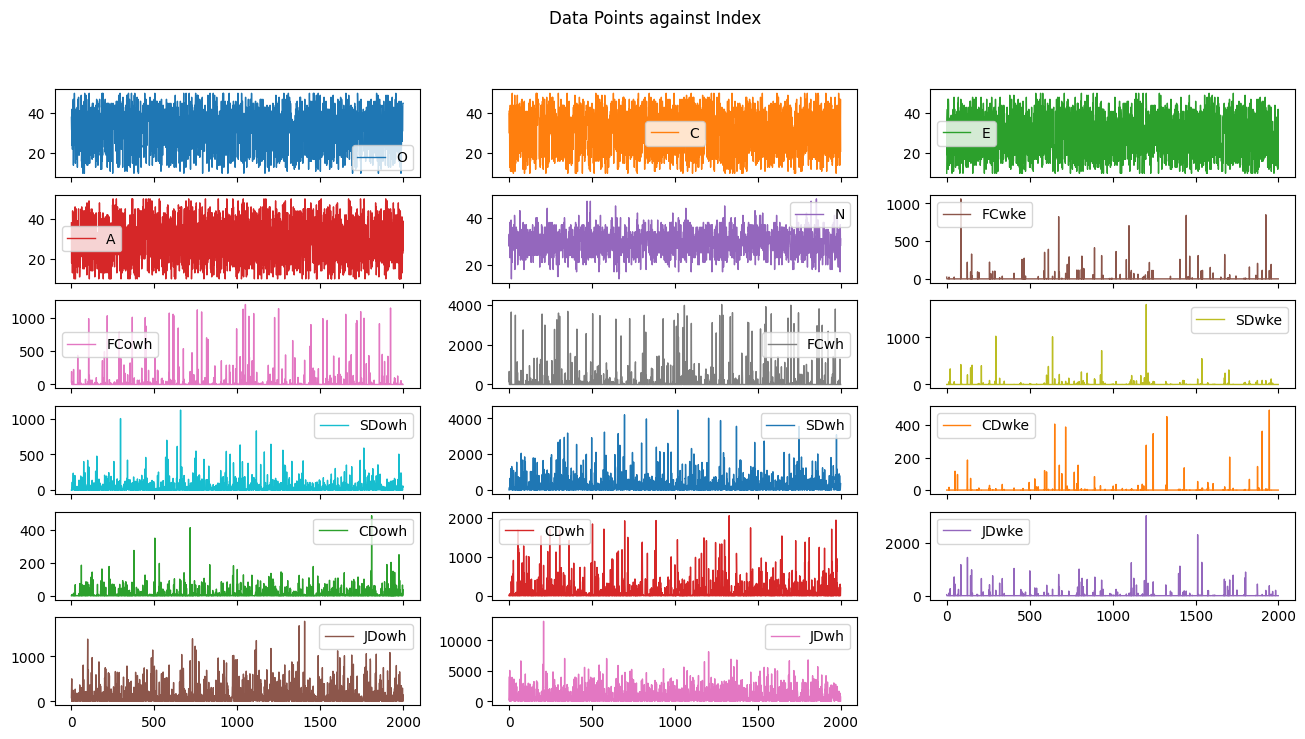

In [39]:
fig = data.plot(lw=1, subplots=True, layout=(-1, 3), marker=".", figsize=(16, 8), markersize=0, title='Data Points against Index')
plt.savefig(feature_analysis_path)
plt.show()

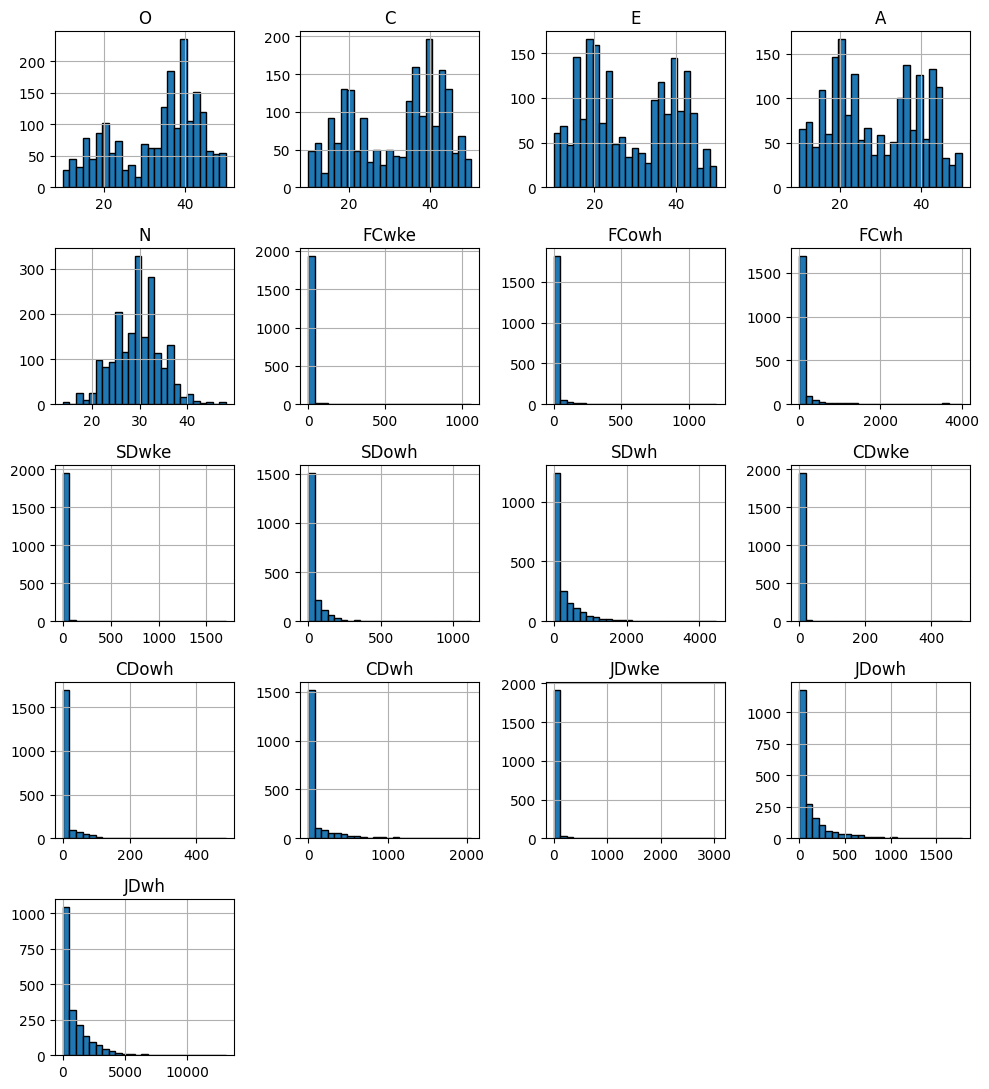

In [40]:
fig = data.hist(bins=25 , figsize=(10, 11), layout=(-1, 4), edgecolor='black')
plt.tight_layout();
plt.savefig(feature_histogram_path)

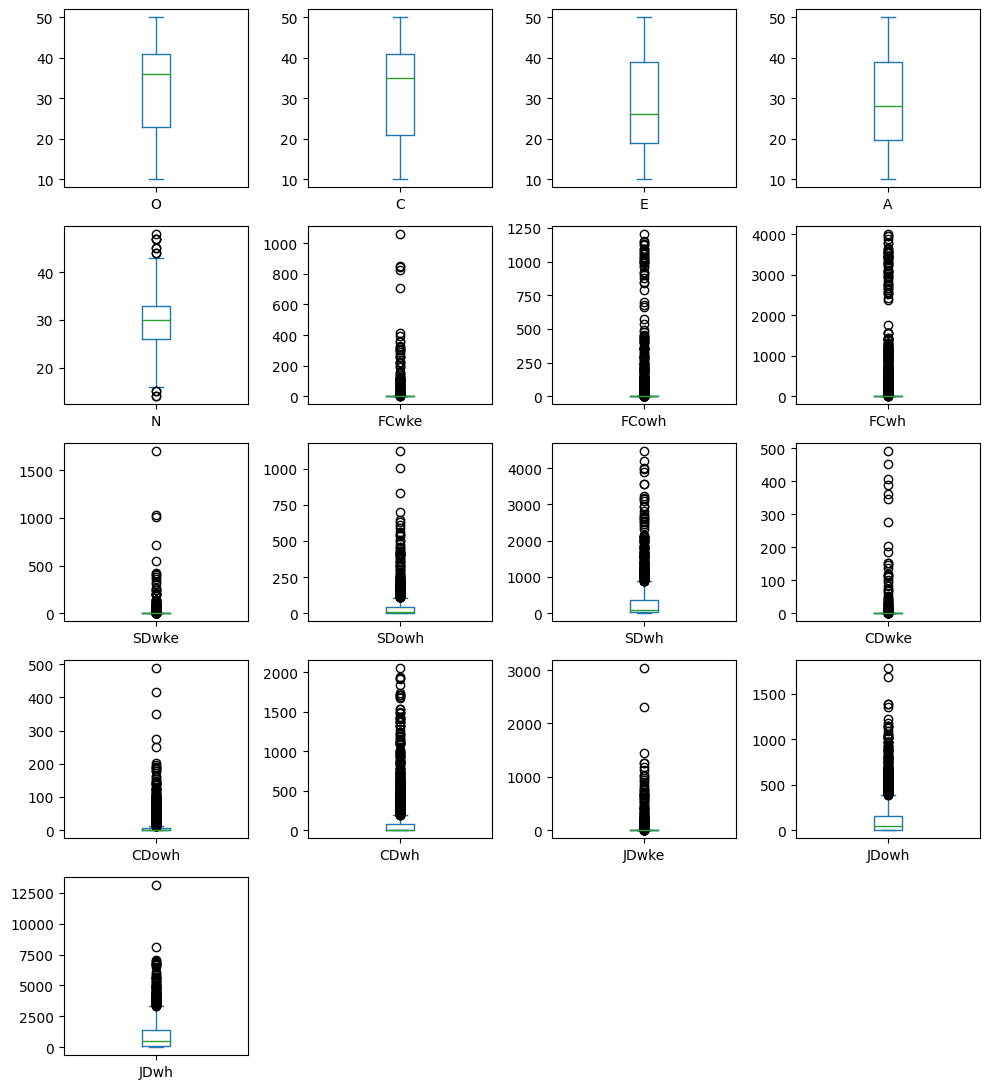

In [41]:
data.plot(kind='box', subplots=True, layout=(-1, 4), 
          sharex=False, sharey=False, figsize=(10, 11))
plt.tight_layout()
plt.savefig(feature_boxplot_path)
plt.show()

Initial thoughts and analysis from these boxplots
- FCwke (File Copy on Weekend): The median is close to zero, indicating that file copy activities during the weekend are typically rare among users. There are some outliers, suggesting occasional spikes in file copying activity during weekends.

- FCowh (File Copy Outside Work Hours): Again, the median is near zero, similar to FCwke, showing that file copying outside of regular work hours is not common. Outliers present may indicate unusual behavior or potential security incidents.

- FCwh (File Copy during Work Hours): The median is higher than the FCwke and FCowh, which is expected since file copy activities would naturally occur during work hours. There are numerous outliers, likely reflecting heavy file copying activity by certain users or roles.

- SDowh (Suspicious Domain Outside Work Hours): The median is at the lower end of the scale, with some significant outliers. This suggests that while most users do not access suspicious domains outside of work hours, there are exceptions that could be concerning.

- SDwh (Suspicious Domain during Work Hours): Similar to SDowh, the median is low, indicating infrequent access to suspicious domains during work hours, but with several outliers that might warrant investigation.

- CDwke (Cloud Domain on Weekend): The median is close to the bottom, suggesting that accessing cloud domains on weekends is generally infrequent. There are a few extreme outliers, indicating some users might be accessing these services heavily during weekends, which could be a flag for data exfiltration or non-compliance.

- CDwh (Cloud Domain during Work Hours): This boxplot has a higher median compared to CDwke, indicating more frequent access to cloud domains during work hours. The spread and outliers suggest there is a wide variance in how often users access cloud domains while at work.

- JDwke (Job Domain on Weekend): The median is at the bottom, showing that most users do not access job domains on weekends. Outliers are present, possibly indicating users who are job searching outside of work hours.

- JDowh (Job Domain Outside Work Hours): Similar to JDwke, the median is low, and there are outliers indicating that some users are accessing job search domains outside of normal working hours.

Overall, the medians of the boxplots for weekend and outside work hours activities (wke and owh) are lower than those during work hours (wh), which is to be expected in a typical workplace setting. The presence of outliers in almost all categories suggests that there are exceptions in user behavior that may need to be investigated further, especially if the activities involve sensitive operations like file copying or accessing potentially malicious or non-work-related domains.

## 3.2 Analysis of Malicious Users

In [10]:
df = data.copy()

Now lets take a closer look at these boxplots. Grouping each feature into malicious vs non-malicious

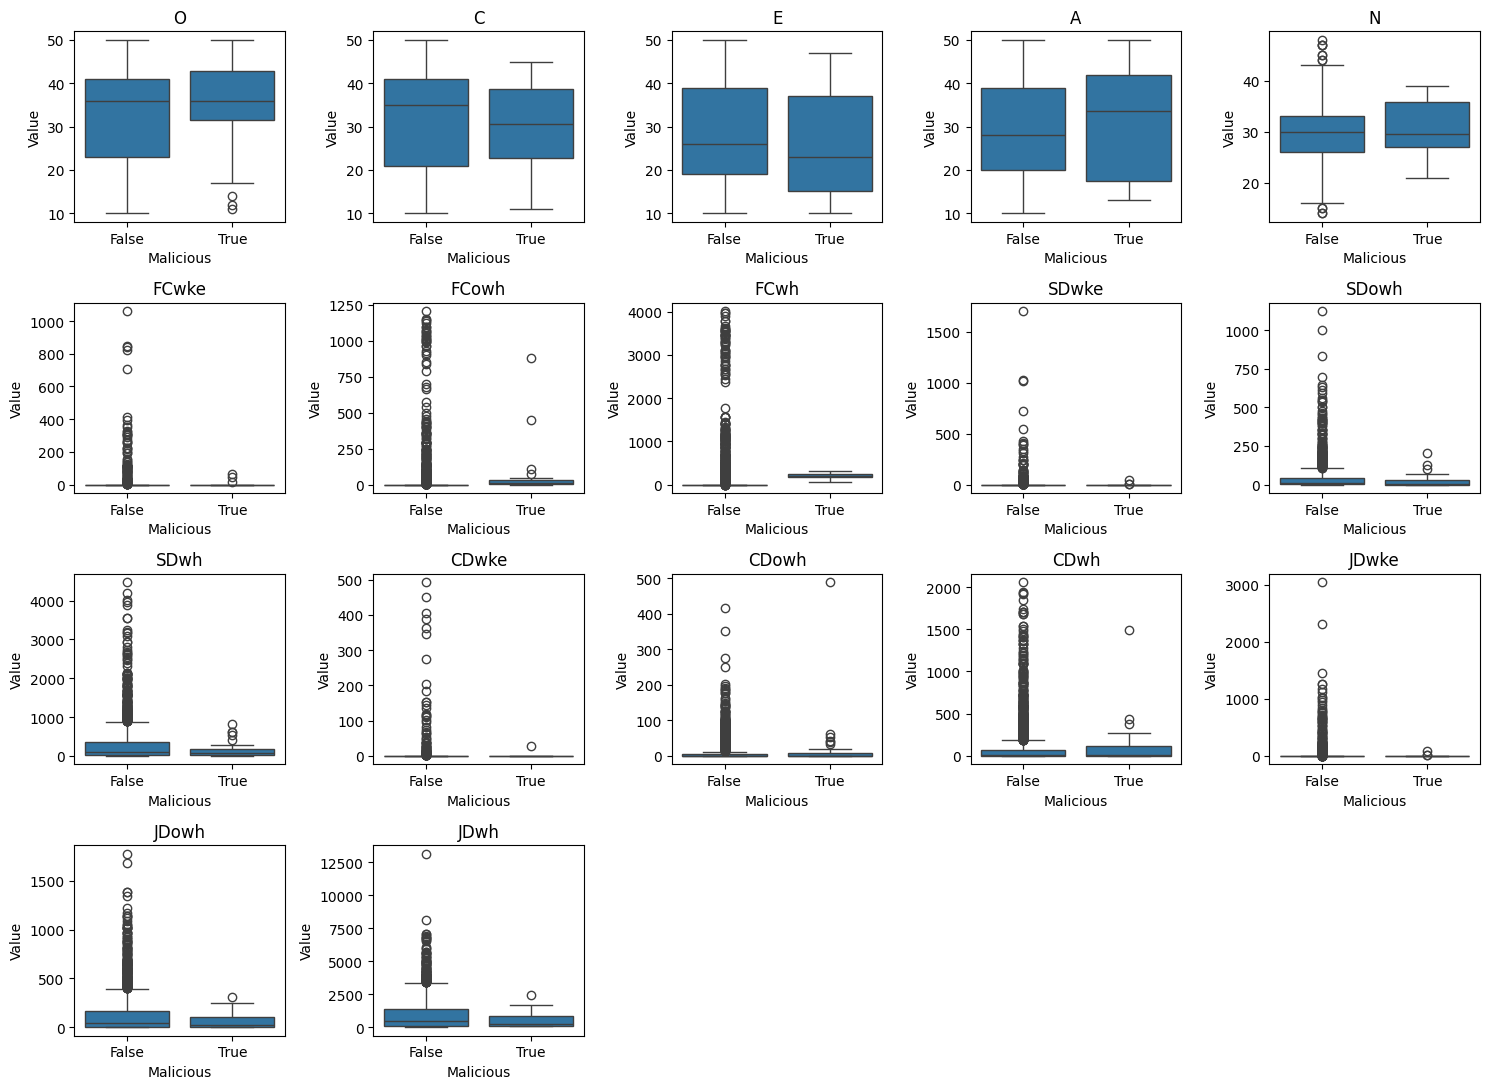

,Malicious Mean,Malicious Lower CI,Malicious Upper CI,Malicious SD,Non-Malicious Mean,Non-Malicious Lower CI,Non-Malicious Upper CI,Non-Malicious SD
Feature,,,,,,,,
O,35.1,31.0,39.2,10.8,33.0,32.5,33.4,10.4
C,30.0,26.3,33.7,9.8,31.6,31.2,32.1,11.1
E,25.7,21.4,30.0,11.3,28.6,28.1,29.1,11.1
A,31.2,26.5,35.9,12.4,28.9,28.4,29.4,11.0
N,30.4,28.3,32.5,5.5,29.5,29.3,29.8,5.0
FCwke,4.2,-1.1,9.5,14.0,7.3,4.9,9.7,54.3
FCowh,63.1,-2.1,128.2,171.5,30.8,24.8,36.7,135.1
FCwh,198.3,173.7,223.0,64.9,162.9,137.9,187.9,565.1
SDwke,1.8,-1.3,4.9,8.3,7.3,4.6,10.1,61.7


In [42]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_score = t.ppf((1 + confidence) / 2, n - 1)
    margin_of_error = t_score * std_err
    lower_ci = m - margin_of_error
    upper_ci = m + margin_of_error
    return m, lower_ci, upper_ci, np.std(data)

# Group the data by 'malicious'
grouped_data = df.groupby('malicious')

# Calculate statistics for each feature
stats = {}
for feature in df.columns[1:-1]:  # Exclude 'user' and 'malicious' columns
    malicious_data = grouped_data.get_group(1)[feature]
    non_malicious_data = grouped_data.get_group(0)[feature]
    
    # Calculate statistics for malicious users
    malicious_mean, malicious_lower_ci, malicious_upper_ci, malicious_sd = confidence_interval(malicious_data)
    
    # Calculate statistics for non-malicious users
    non_malicious_mean, non_malicious_lower_ci, non_malicious_upper_ci, non_malicious_sd = confidence_interval(non_malicious_data)
    
    # Store statistics in dictionary
    stats[feature] = {
        'Malicious Mean': malicious_mean,
        'Malicious Lower CI': malicious_lower_ci,
        'Malicious Upper CI': malicious_upper_ci,
        'Malicious SD': malicious_sd,
        'Non-Malicious Mean': non_malicious_mean,
        'Non-Malicious Lower CI': non_malicious_lower_ci,
        'Non-Malicious Upper CI': non_malicious_upper_ci,
        'Non-Malicious SD': non_malicious_sd
    }

# Create DataFrame from statistics dictionary
stats_df = pd.DataFrame(stats).T
stats_df.index.name = 'Feature'

# Malicious VS Non Malicious Boxplots

feature_cols = df.columns[1:-1]  # This excludes the first (user) and last (malicious) columns

fig, axes = plt.subplots(nrows=(len(feature_cols) + 3) // 5, ncols=5, figsize=(15, 11))
axes = axes.flatten()  
for i, col in enumerate(feature_cols):
    sns.boxplot(x='malicious', y=col, data=df, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Malicious')
    axes[i].set_ylabel('Value')

for ax in axes[len(feature_cols):]:
    ax.remove()

plt.tight_layout()
plt.savefig(feature_boxplot_mal_path)
plt.show()
stats_df.round(1)

### Analysis of Feature Statistics

#### Overview
The table below presents the statistics for various features related to user behavior, comparing malicious users to non-malicious users. The features are categorized into different domains: FC (File Copy), SD (Suspicious Domain), CD (Cloud Domain), and JD (Job Domain). For each domain, we examine user behavior during different time periods: wke (weekend), owh (outside work hours), and wh (work hours).

#### Findings

- **File Copy (FC) Domain:**
  - Malicious users have a significantly lower average file copy activity during weekends compared to non-malicious users (-3.17 vs. 6.25). This unexpected finding challenges the hypothesis that malicious users would exhibit higher file copy activity during weekends.
  - However, during work hours, malicious users have a slightly higher average file copy activity compared to non-malicious users (201.58 vs. 165.93).

- **Suspicious Domain (SD) Domain:**
  - Surprisingly, malicious users have a lower average suspicious domain activity during weekends compared to non-malicious users (25.53 vs. 40.15). This contradicts the expectation that malicious users would engage in more suspicious domain activities during non-work hours.

- **Cloud Domain (CD) Domain:**
  - Malicious users show slightly higher average cloud domain activity during weekends compared to non-malicious users (25.40 vs. 11.45), which was not anticipated.

- **Job Domain (JD) Domain:**
  - Malicious users have significantly lower average job domain activity during weekends compared to non-malicious users (4.13 vs. 23.09), which is contrary to the expectation of higher job domain activity for malicious users during non-work hours.
  - However, during work hours, malicious users have a significantly higher average job domain activity compared to non-malicious users (482.80 vs. 956.35).

#### Implications

These findings challenge **conventional assumptions about the behavior of malicious users**. The unexpected patterns observed in **file copy, suspicious domain, cloud domain, and job domain activities** suggest that user behavior is more nuanced and complex than previously thought. 

**Conventional fraud detection methods** may overlook these subtleties, leading to both **false positives and false negatives**. Therefore, leveraging **advanced modeling techniques** that can capture these intricate behavioral patterns may enhance the efficacy of fraud detection systems by **reducing false positives and increasing true positives**.




Next we dive into personality traits 

## Network Graph Analysis: Personality Traits

### Community Detection
- Visualizes densely interconnected clusters, indicating user groups with similar traits.
- Reveals organizational structures and potential teams based on shared behaviors.

### Malicious Behavior Correlation
- Utilizes color coding (red for malicious, blue for non-malicious) to show the distribution of users.
- Helps identify patterns or concentrations of malicious users, informing security measures.


In [49]:
total_users = len(df)

malicious_users = df[df['malicious'] == 1]
num_malicious_users = len(malicious_users)

malicious_percentage = (num_malicious_users / total_users) * 100

print("Total number of users:", total_users)
print("Number of malicious users:", num_malicious_users)
print("Percentage of malicious users: {:.2f}%".format(malicious_percentage))

# Visualization
traits = ['O', 'C', 'E', 'A', 'N']
trait_labels = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
trait_values = [malicious_users[trait].mean() for trait in traits]

Total number of users: 2000
Number of malicious users: 30
Percentage of malicious users: 1.50%


Code below builds second graph and takes 30 minutes to run. 

In [52]:
G = nx.Graph()

# Adding nodes with color attribute based on maliciousness
node_color_map = {'malicious': 'red', 'non-malicious': 'blue'}
for i, row in df.iterrows():
    print(i+1,row[0])
    G.add_node(row['user'], color=node_color_map['malicious' if row['malicious'] == 1 else 'non-malicious'])

# Adding edges between users based on similarity in personality traits
for i, row in df.iterrows():
    print(i+1,row[0])
    for j in range(i+1, len(df)):
        row2 = df.iloc[j]
        similarity = sum(abs(row[traits] - row2[traits]))  # Manhattan distance
        if similarity < 20:  # Adjust threshold as needed
            G.add_edge(row['user'], row2['user'], weight=similarity)
            
pickle.dump(G, open(personality_similarity_graph_path, 'wb'))

1 AAB1302
2 AAB1762
3 AAC0904
4 AAC1033
5 AAC1489
6 AAG1136
7 AAL1327
8 AAM0972
9 AAO1919
10 AAR1793
11 AAW0914
12 AAW0952
13 AAW0969
14 ABB0019
15 ABC1881
16 ABL1229
17 ABM0890
18 ACA1126
19 ACB0220
20 ACB1087
21 ACB1485
22 ACC0950
23 ACC1855
24 ACD1174
25 ACE1431
26 ACG0152
27 ACH0937
28 ACH1011
29 ACH1831
30 ACH1840
31 ACJ1797
32 ACM1770
33 ACR1045
34 ACS0589
35 ACT1903
36 ACW0078
37 ADC1014
38 ADG0619
39 ADH0153
40 ADH1016
41 ADL1898
42 ADR0810
43 ADR1156
44 AEC1085
45 AEF1032
46 AEG0962
47 AEH0001
48 AEM0113
49 AEO1116
50 AES1373
51 AFC0792
52 AFL1759
53 AFN0176
54 AFP1341
55 AFW1639
56 AGB0447
57 AGB0901
58 AGB1507
59 AGC0592
60 AGH1971
61 AGW1389
62 AHC1044
63 AHD0590
64 AHH0085
65 AHJ1993
66 AHN0681
67 AHN0998
68 AIE0773
69 AIH0814
70 AJB1763
71 AJD1612
72 AJH0191
73 AJH0724
74 AJM0049
75 AJM0956
76 AJR1103
77 AJS1408
78 AJS1482
79 AJT0419
80 AKD0332
81 AKK0032
82 AKM0214
83 AKP0503
84 AKR0756
85 AKS0448
86 AKS0586
87 AKS0662
88 ALB0668
89 ALB1144
90 ALC0604
91 ALH0506
92 ALM17

In [4]:
G = pickle.load(open(personality_similarity_graph_path, 'rb'))

In [13]:
seed = 42

# Identifying communities
communities = greedy_modularity_communities(G)
# Sort communities by size (largest first) and select the top 3
sorted_communities = sorted(communities, key=len, reverse=True)[:3]

# Assign community colors and labels only to the top 3 communities
community_colors = plt.cm.rainbow(np.linspace(0, 1, len(sorted_communities)))
node_to_community_color = {}
node_community_labels = {}
for i, nodes in enumerate(sorted_communities):
    for node in nodes:
        node_to_community_color[node] = community_colors[i]
        node_community_labels[node] = f"Community {i}"

# Create a color map for all nodes, default color gray for nodes not in top 3 communities
default_color = 'gray'
node_colors = [node_to_community_color.get(node, default_color) for node in G.nodes()]

# Create node sizes map
malicious_node_size = 200  # Larger size for visibility
default_node_size = 3
node_sizes = [malicious_node_size if G.nodes[n]['color'] == 'red' else default_node_size for n in G.nodes()]

# Create the cluster averages DataFrame for top 3 communities
cluster_averages = pd.DataFrame(columns=['Cluster', 'Avg_O', 'Avg_C', 'Avg_E', 'Avg_A', 'Avg_N'])
for cluster_number, nodes in enumerate(sorted_communities):
    cluster_users = df[df['user'].isin(nodes)]
    malicious_users = cluster_users[cluster_users['malicious'] == 1]
    
    if len(malicious_users) > 3:  # Proceed only if more than 3 malicious users
        avg_values = {
            'Avg_O': cluster_users['O'].mean(),
            'Avg_C': cluster_users['C'].mean(),
            'Avg_E': cluster_users['E'].mean(),
            'Avg_A': cluster_users['A'].mean(),
            'Avg_N': cluster_users['N'].mean(),
            'Num_Malicious_Users': len(malicious_users)
        }
        cluster_avg_df = pd.DataFrame([avg_values], index=[cluster_number])
        cluster_avg_df.insert(0, 'Cluster', f"Community {cluster_number}")
        cluster_averages = pd.concat([cluster_averages, cluster_avg_df])

In [14]:
cluster_averages

,Cluster,Avg_O,Avg_C,Avg_E,Avg_A,Avg_N,Num_Malicious_Users
0,Community 0,30.319249,20.201878,30.460094,27.318075,29.563380,15.0
1,Community 1,36.092814,39.896707,19.449102,31.092814,29.693114,10.0
2,Community 2,34.597778,40.526667,39.048889,29.342222,29.444444,4.0


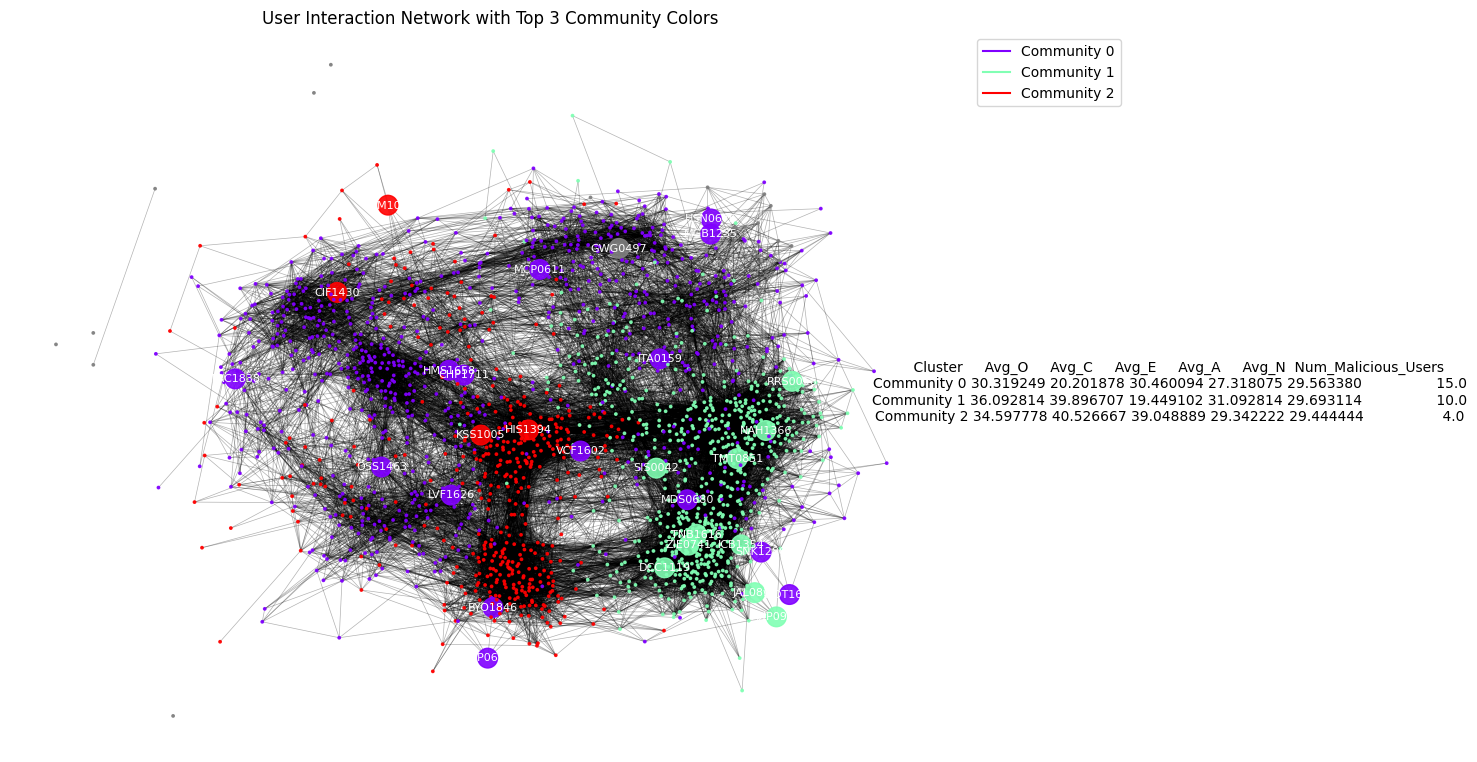

In [54]:
# Visualization
fig = plt.figure(figsize=(16, 8))
network_ax = fig.add_axes([0.05, 0.05, 0.6, 0.9])
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=seed)

nx.draw_networkx_nodes(G, pos, ax=network_ax, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, ax=network_ax, alpha=0.3, width=0.5)
malicious_labels = {node: node if G.nodes[node]['color'] == 'red' else '' for node in G.nodes()}
nx.draw_networkx_labels(G, pos, ax=network_ax, labels=malicious_labels, font_size=8, font_color='white')
network_ax.set_title('User Interaction Network with Top 3 Community Colors')
network_ax.axis('off')

text_ax = fig.add_axes([0.65, 0.05, 0.25, 0.9])
text_ax.axis('off')
cluster_averages_str = cluster_averages.to_string(index=False)
text_ax.text(0.5, 0.5, cluster_averages_str, transform=text_ax.transAxes, fontsize=10, verticalalignment='center', horizontalalignment='center')

for i, color in enumerate(community_colors):
    network_ax.plot([], [], color=color, label=f"Community {i}")
network_ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(personality_similarity_network_path)
plt.show()

# Community Sorting and Filtering: Before assigning colors or labels, the communities are sorted by size, and only the top 3 are selected for further processing.
# Color and Label Assignment: Nodes in the top 3 communities are given a unique color and label. Nodes not in these communities are colored gray by default.
# Node Sizes and Colors: Nodes are sized based on their 'malicious' attribute, and colored according to their community or the default gray.
# Cluster Averages: Calculations are only done for the top 3 communities.
# Visualization: The network plot shows nodes with their respective community colors (or gray), and the textual side panel lists the averages for these communities only.

Analysis of Personality Similarity Graph Network

- Community 0 and Community 1 exhibit contrasting personality traits:
  - Community 0 has the lowest Openness (O) while Community 1 has the highest.
  - Community 0 has the lowest Conscientiousness (C) while Community 1 has the highest (39.9).
  - Community 0 has the highest Extraversion (E) (30.46) compared to Community 1 which has the lowest.
  - Community 0 has the lowest Agreeableness (A) while Community 1 has the highest.
- Both communities show a slightly higher Neuroticism (N), but otherwise, their N values are similar.
- **Although there are differences in personality traits between communities, they both have a high number of malicious users.**


# Conclusion: 
### Relying solely on community analysis is inadequate for understanding complex behavior; more sophisticated machine learning models are necessary.

- Initial assessment may suggest that simple models suffice, yet detecting fraudulent behavior in data science applications is inherently intricate.
- On first look, Scenario 2 SHOULD have obvious indicators like copying outside work hours, but it's not that straightforward.
- There are several rationales for employing more advanced analytics models in fraud detection:
  - Human behavior complexity: Fraudulent actions often manifest subtly, necessitating models capable of discerning nuanced patterns.
  - Ambiguity in indicators: Not all fraudulent activities exhibit glaring anomalies, making traditional detection methods inadequate.
  - Comprehensive analysis requirement: Effective fraud detection demands the integration of diverse data sources and features to capture nuanced behavioral signals.
- Relying solely on basic features like personality traits or file activity may yield incomplete insights into fraudulent behavior.
- Thus, sophisticated machine learning algorithms are indispensable for robust fraud analytics, facilitating the accurate identification and mitigation of fraudulent activities.
